# ComicBoost: A/B Testing and Feature Analysis for Comic App User Engagement

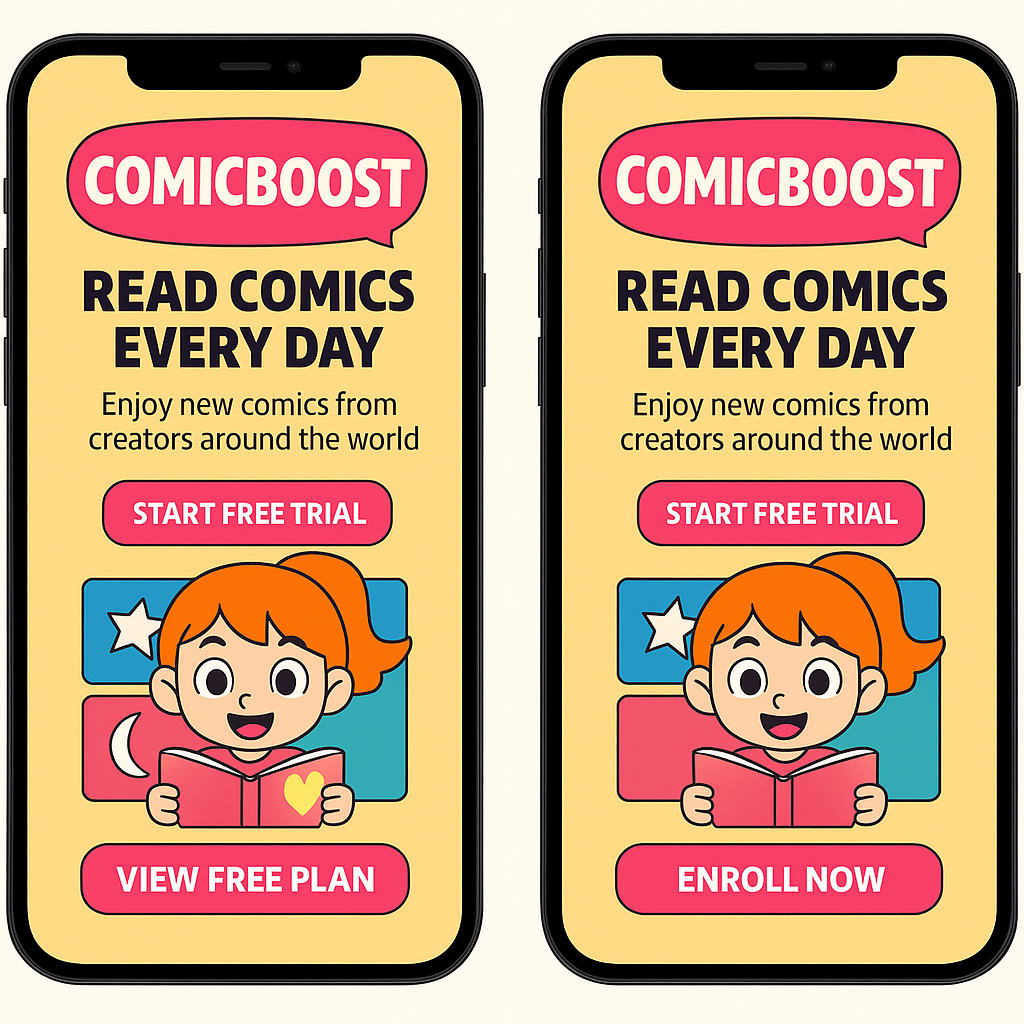

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, chi2_contingency, fisher_exact
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, average_precision_score)
from sklearn.inspection import permutation_importance
import shap

# Set style for professional plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Section 1: Data Loading and Exploration

In [3]:
# Load and inspect data
df = pd.read_csv('comic-app-abtesting.csv')

print("Dataset Overview:")
print(f"Total observations: {len(df):,}")
print(f"Features: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

Dataset Overview:
Total observations: 20,000
Features: ['user_id', 'click', 'group', 'timestamp', 'age', 'sessions_last_30d', 'pages_per_session', 'time_on_site_min', 'country', 'timezone', 'device_type', 'browser', 'connection_speed', 'is_returning_user', 'email_subscriber', 'cart_abandonment_rate', 'hour_of_day', 'day_of_week', 'is_weekend', 'treatment', 'converted']
Data types:
user_id                    int64
click                      int64
group                     object
timestamp                 object
age                        int64
sessions_last_30d          int64
pages_per_session        float64
time_on_site_min         float64
country                   object
timezone                  object
device_type               object
browser                   object
connection_speed          object
is_returning_user          int64
email_subscriber           int64
cart_abandonment_rate    float64
hour_of_day                int64
day_of_week                int64
is_weekend            

## Section 2: Data Quality Assessment

In [4]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Validate data integrity
print("\nData Validation:")
print(f"Unique groups: {df['group'].unique()}")
print(f"Unique click values: {df['click'].unique()}")
print(f"Click value types: {df['click'].dtype}")

# Check group balance
group_balance = df['group'].value_counts()
print(f"\nGroup Distribution:")
for group, count in group_balance.items():
    print(f"{group}: {count:,} ({count/len(df)*100:.1f}%)")

Missing values:
user_id                      0
click                        0
group                        0
timestamp                10000
age                          0
sessions_last_30d            0
pages_per_session            0
time_on_site_min             0
country                      0
timezone                     0
device_type                  0
browser                      0
connection_speed             0
is_returning_user            0
email_subscriber             0
cart_abandonment_rate        0
hour_of_day                  0
day_of_week                  0
is_weekend                   0
treatment                    0
converted                    0
dtype: int64

Duplicate rows: 0

Data Validation:
Unique groups: ['exp' 'con']
Unique click values: [1 0]
Click value types: int64

Group Distribution:
exp: 10,000 (50.0%)
con: 10,000 (50.0%)


## Section 3: Exploratory Data Analysis

In [5]:
# Calculate key metrics
summary_stats = df.groupby('group').agg({
    'click': ['count', 'sum', 'mean', 'std']
}).round(4)

summary_stats.columns = ['Total_Users', 'Total_Clicks', 'Click_Rate', 'Click_Rate_Std']
print("Summary Statistics by Group:")
print(summary_stats)

# Calculate additional metrics
control_users = len(df[df['group'] == 'con'])
exp_users = len(df[df['group'] == 'exp'])
control_clicks = df[df['group'] == 'con']['click'].sum()
exp_clicks = df[df['group'] == 'exp']['click'].sum()

control_rate = control_clicks / control_users
exp_rate = exp_clicks / exp_users
relative_lift = (exp_rate - control_rate) / control_rate * 100

print(f"\nKey Metrics:")
print(f"Control Group - Users: {control_users:,}, Clicks: {control_clicks:,}, Rate: {control_rate:.4f}")
print(f"Experimental Group - Users: {exp_users:,}, Clicks: {exp_clicks:,}, Rate: {exp_rate:.4f}")
print(f"Absolute Lift: {exp_rate - control_rate:.4f}")
print(f"Relative Lift: {relative_lift:.2f}%")

Summary Statistics by Group:
       Total_Users  Total_Clicks  Click_Rate  Click_Rate_Std
group                                                       
con          10000          1989      0.1989          0.3992
exp          10000          6116      0.6116          0.4874

Key Metrics:
Control Group - Users: 10,000, Clicks: 1,989, Rate: 0.1989
Experimental Group - Users: 10,000, Clicks: 6,116, Rate: 0.6116
Absolute Lift: 0.4127
Relative Lift: 207.49%


## Section 4: Visualizations

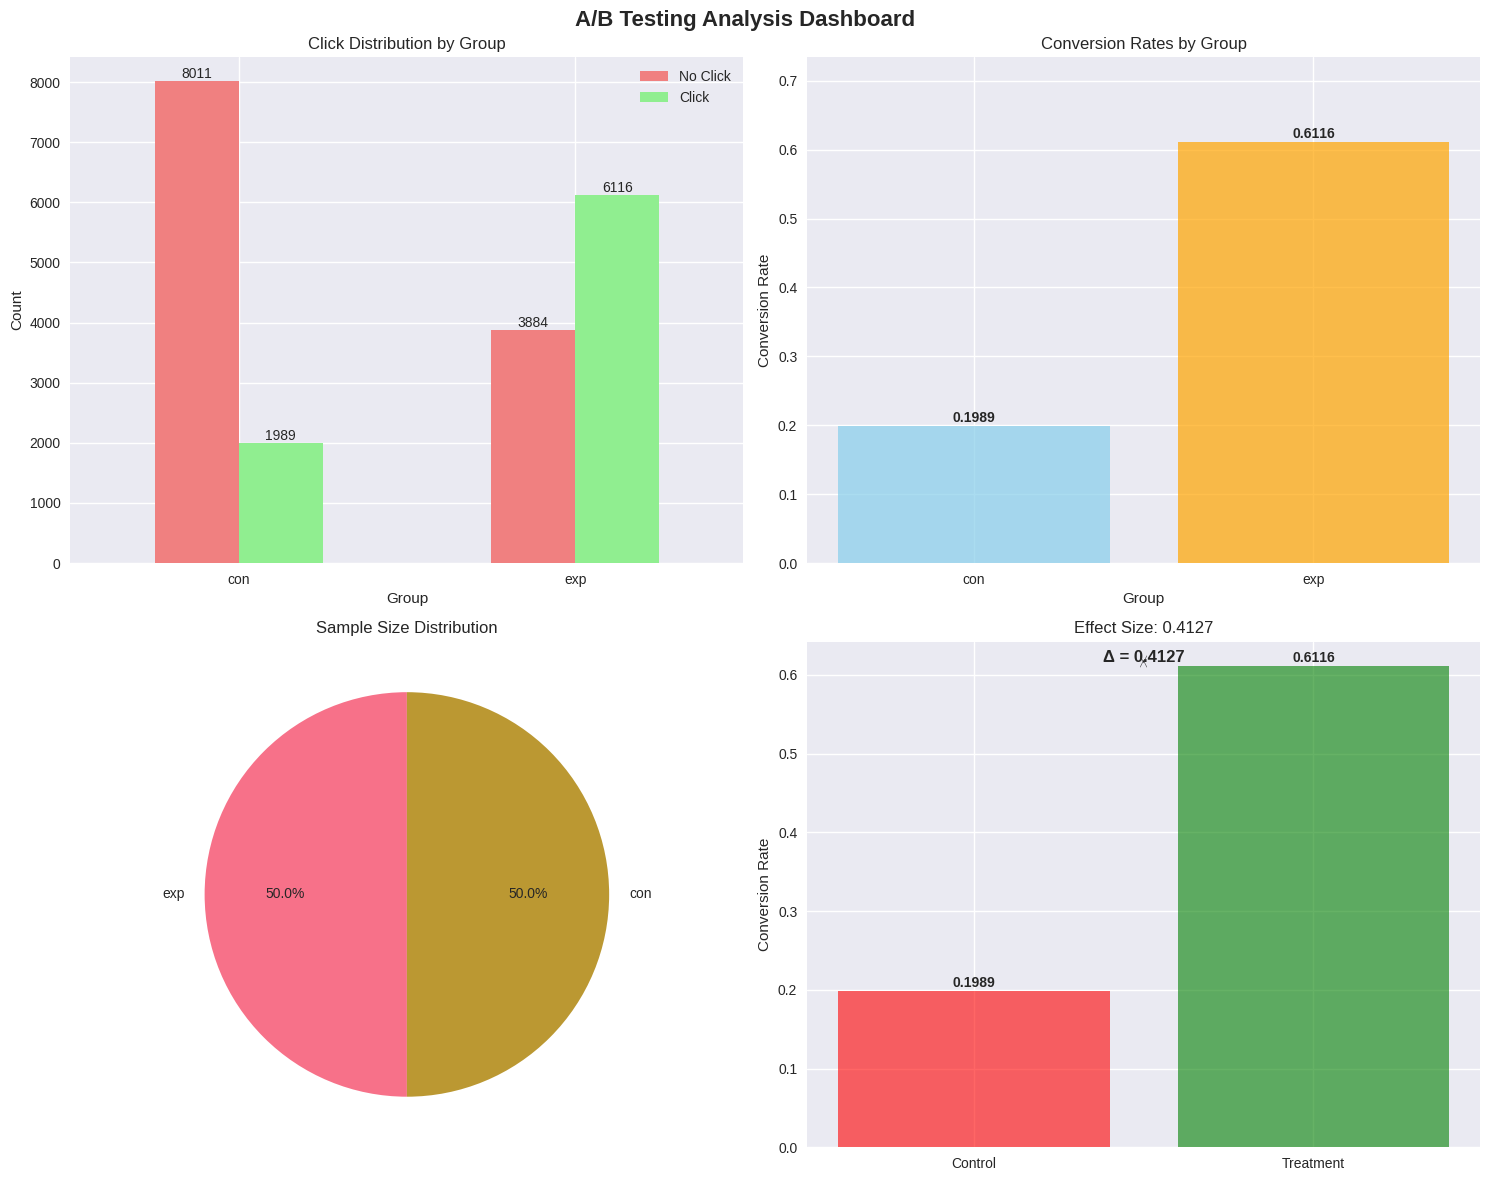

In [8]:
# Create comprehensive visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('A/B Testing Analysis Dashboard', fontsize=16, fontweight='bold')

# Plot 1: Click Distribution
ax1 = axes[0, 0]
click_dist = df.groupby(['group', 'click']).size().unstack(fill_value=0)
click_dist.plot(kind='bar', ax=ax1, color=['lightcoral', 'lightgreen'])
ax1.set_title('Click Distribution by Group')
ax1.set_xlabel('Group')
ax1.set_ylabel('Count')
ax1.legend(['No Click', 'Click'])
ax1.tick_params(axis='x', rotation=0)

# Add percentage labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d')

# Plot 2: Conversion Rates
ax2 = axes[0, 1]
conversion_rates = df.groupby('group')['click'].mean()
bars = ax2.bar(conversion_rates.index, conversion_rates.values,
               color=['skyblue', 'orange'], alpha=0.7)
ax2.set_title('Conversion Rates by Group')
ax2.set_xlabel('Group')
ax2.set_ylabel('Conversion Rate')
ax2.set_ylim(0, max(conversion_rates.values) * 1.2)

# Add value labels on bars
for bar, rate in zip(bars, conversion_rates.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{rate:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Sample Size by Group
ax3 = axes[1, 0]
sample_sizes = df['group'].value_counts()
wedges, texts, autotexts = ax3.pie(sample_sizes.values, labels=sample_sizes.index,
                                  autopct='%1.1f%%', startangle=90)
ax3.set_title('Sample Size Distribution')

# Plot 4: Effect Size Visualization
ax4 = axes[1, 1]
effect_size = exp_rate - control_rate
x_pos = ['Control', 'Treatment']
y_pos = [control_rate, exp_rate]
bars = ax4.bar(x_pos, y_pos, color=['red', 'green'], alpha=0.6)
ax4.set_title(f'Effect Size: {effect_size:.4f}')
ax4.set_ylabel('Conversion Rate')

# Add difference annotation
ax4.annotate(f'Δ = {effect_size:.4f}',
            xy=(0.5, max(y_pos)), xytext=(0.5, max(y_pos) + 0.005),
            ha='center', fontweight='bold', fontsize=12,
            arrowprops=dict(arrowstyle='<->', color='black'))

for bar, rate in zip(bars, y_pos):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{rate:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Section 5: Statistical Power Analysis

In [7]:
# Define test parameters
alpha = 0.05  # Significance level
beta = 0.20   # Type II error rate (Power = 1 - β = 0.80)
power = 1 - beta

print(f"Test Parameters:")
print(f"• Significance Level (α): {alpha}")
print(f"• Power (1-β): {power}")
print(f"• Type II Error Rate (β): {beta}")

# Calculate effect size (Cohen's h for proportions)
p1, p2 = control_rate, exp_rate
cohens_h = 2 * (np.arcsin(np.sqrt(p2)) - np.arcsin(np.sqrt(p1)))

print(f"\nEffect Size Metrics:")
print(f"• Absolute Effect Size: {abs(p2 - p1):.4f}")
print(f"• Relative Effect Size: {abs(relative_lift):.2f}%")
print(f"• Cohen's h: {abs(cohens_h):.4f}")

# Effect size interpretation
if abs(cohens_h) < 0.2:
    effect_magnitude = "Small"
elif abs(cohens_h) < 0.5:
    effect_magnitude = "Medium"
else:
    effect_magnitude = "Large"

print(f"• Effect Magnitude: {effect_magnitude}")

Test Parameters:
• Significance Level (α): 0.05
• Power (1-β): 0.8
• Type II Error Rate (β): 0.2

Effect Size Metrics:
• Absolute Effect Size: 0.4127
• Relative Effect Size: 207.49%
• Cohen's h: 0.8714
• Effect Magnitude: Large


## Section 6: Hypothesis Testing

- H₀: p_treatment = p_control (no difference in conversion rates)
- H₁: p_treatment ≠ p_control (significant difference exists)

In [9]:
# Method 1: Two-sample Z-test for proportions
print("\n--- METHOD 1: Two-Sample Z-Test ---")

# Calculate pooled proportion
n1, n2 = control_users, exp_users
x1, x2 = control_clicks, exp_clicks
p_pooled = (x1 + x2) / (n1 + n2)

# Standard error
se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))

# Test statistic
z_stat = (exp_rate - control_rate) / se

# P-value (two-tailed)
p_value_z = 2 * (1 - norm.cdf(abs(z_stat)))

# Critical value
z_critical = norm.ppf(1 - alpha/2)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value_z:.6f}")
print(f"Critical value (±): {z_critical:.4f}")


--- METHOD 1: Two-Sample Z-Test ---
Z-statistic: 59.4416
P-value: 0.000000
Critical value (±): 1.9600


In [10]:
# Method 2: Chi-square test
print("\n--- METHOD 2: Chi-Square Test ---")

# Create contingency table
contingency_table = pd.crosstab(df['group'], df['click'])
print("Contingency Table:")
print(contingency_table)

chi2_stat, p_value_chi2, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value_chi2:.6f}")
print(f"Degrees of freedom: {dof}")


--- METHOD 2: Chi-Square Test ---
Contingency Table:
click     0     1
group            
con    8011  1989
exp    3884  6116

Chi-square statistic: 3531.5957
P-value: 0.000000
Degrees of freedom: 1


In [11]:
# Method 3: Fisher's Exact Test (for small samples)
print("\n--- METHOD 3: Fisher's Exact Test ---")

# Extract values for Fisher's test
table = [[control_users - control_clicks, control_clicks],
         [exp_users - exp_clicks, exp_clicks]]

odds_ratio, p_value_fisher = fisher_exact(table)

print(f"Odds Ratio: {odds_ratio:.4f}")
print(f"P-value: {p_value_fisher:.6f}")


--- METHOD 3: Fisher's Exact Test ---
Odds Ratio: 6.3422
P-value: 0.000000


## Section 7: Confidence Intervals

In [12]:
# Confidence interval for difference in proportions
diff = exp_rate - control_rate
se_diff = np.sqrt((control_rate * (1 - control_rate) / control_users) +
                  (exp_rate * (1 - exp_rate) / exp_users))

# 95% Confidence Interval
ci_lower = diff - z_critical * se_diff
ci_upper = diff + z_critical * se_diff

print(f"Difference in Conversion Rates: {diff:.4f}")
print(f"Standard Error of Difference: {se_diff:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# Confidence intervals for individual rates
ci_control = [control_rate - 1.96 * np.sqrt(control_rate * (1-control_rate) / control_users),
              control_rate + 1.96 * np.sqrt(control_rate * (1-control_rate) / control_users)]

ci_treatment = [exp_rate - 1.96 * np.sqrt(exp_rate * (1-exp_rate) / exp_users),
                exp_rate + 1.96 * np.sqrt(exp_rate * (1-exp_rate) / exp_users)]

print(f"\n95% CI for Control Rate: [{ci_control[0]:.4f}, {ci_control[1]:.4f}]")
print(f"95% CI for Treatment Rate: [{ci_treatment[0]:.4f}, {ci_treatment[1]:.4f}]")

Difference in Conversion Rates: 0.4127
Standard Error of Difference: 0.0063
95% Confidence Interval: [0.4004, 0.4250]

95% CI for Control Rate: [0.1911, 0.2067]
95% CI for Treatment Rate: [0.6020, 0.6212]


## Section 8: Results Interpretation and Decisions

In [13]:
# Statistical significance
is_significant = p_value_z < alpha

print(f"Statistical Significance Test:")
print(f"• P-value ({p_value_z:.6f}) {'<' if is_significant else '≥'} α ({alpha})")
print(f"• Result: {'STATISTICALLY SIGNIFICANT' if is_significant else 'NOT STATISTICALLY SIGNIFICANT'}")

if is_significant:
    print(f"• Interpretation: There is strong evidence that the treatment effect is real")
    print(f"  (probability of observing this difference by chance < {alpha*100}%)")
else:
    print(f"• Interpretation: Insufficient evidence to conclude a treatment effect exists")
    print(f"  (difference could be due to random variation)")

# Practical significance
mde = 0.01  # Minimum Detectable Effect (1% absolute improvement)
is_practically_significant = abs(diff) >= mde and ci_lower > 0

print(f"\nPractical Significance Test:")
print(f"• Observed Effect: {diff:.4f}")
print(f"• Minimum Detectable Effect: {mde:.4f}")
print(f"• Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"• Result: {'PRACTICALLY SIGNIFICANT' if is_practically_significant else 'NOT PRACTICALLY SIGNIFICANT'}")

Statistical Significance Test:
• P-value (0.000000) < α (0.05)
• Result: STATISTICALLY SIGNIFICANT
• Interpretation: There is strong evidence that the treatment effect is real
  (probability of observing this difference by chance < 5.0%)

Practical Significance Test:
• Observed Effect: 0.4127
• Minimum Detectable Effect: 0.0100
• Confidence Interval: [0.4004, 0.4250]
• Result: PRACTICALLY SIGNIFICANT


## Section 9: Statistical Visualizations

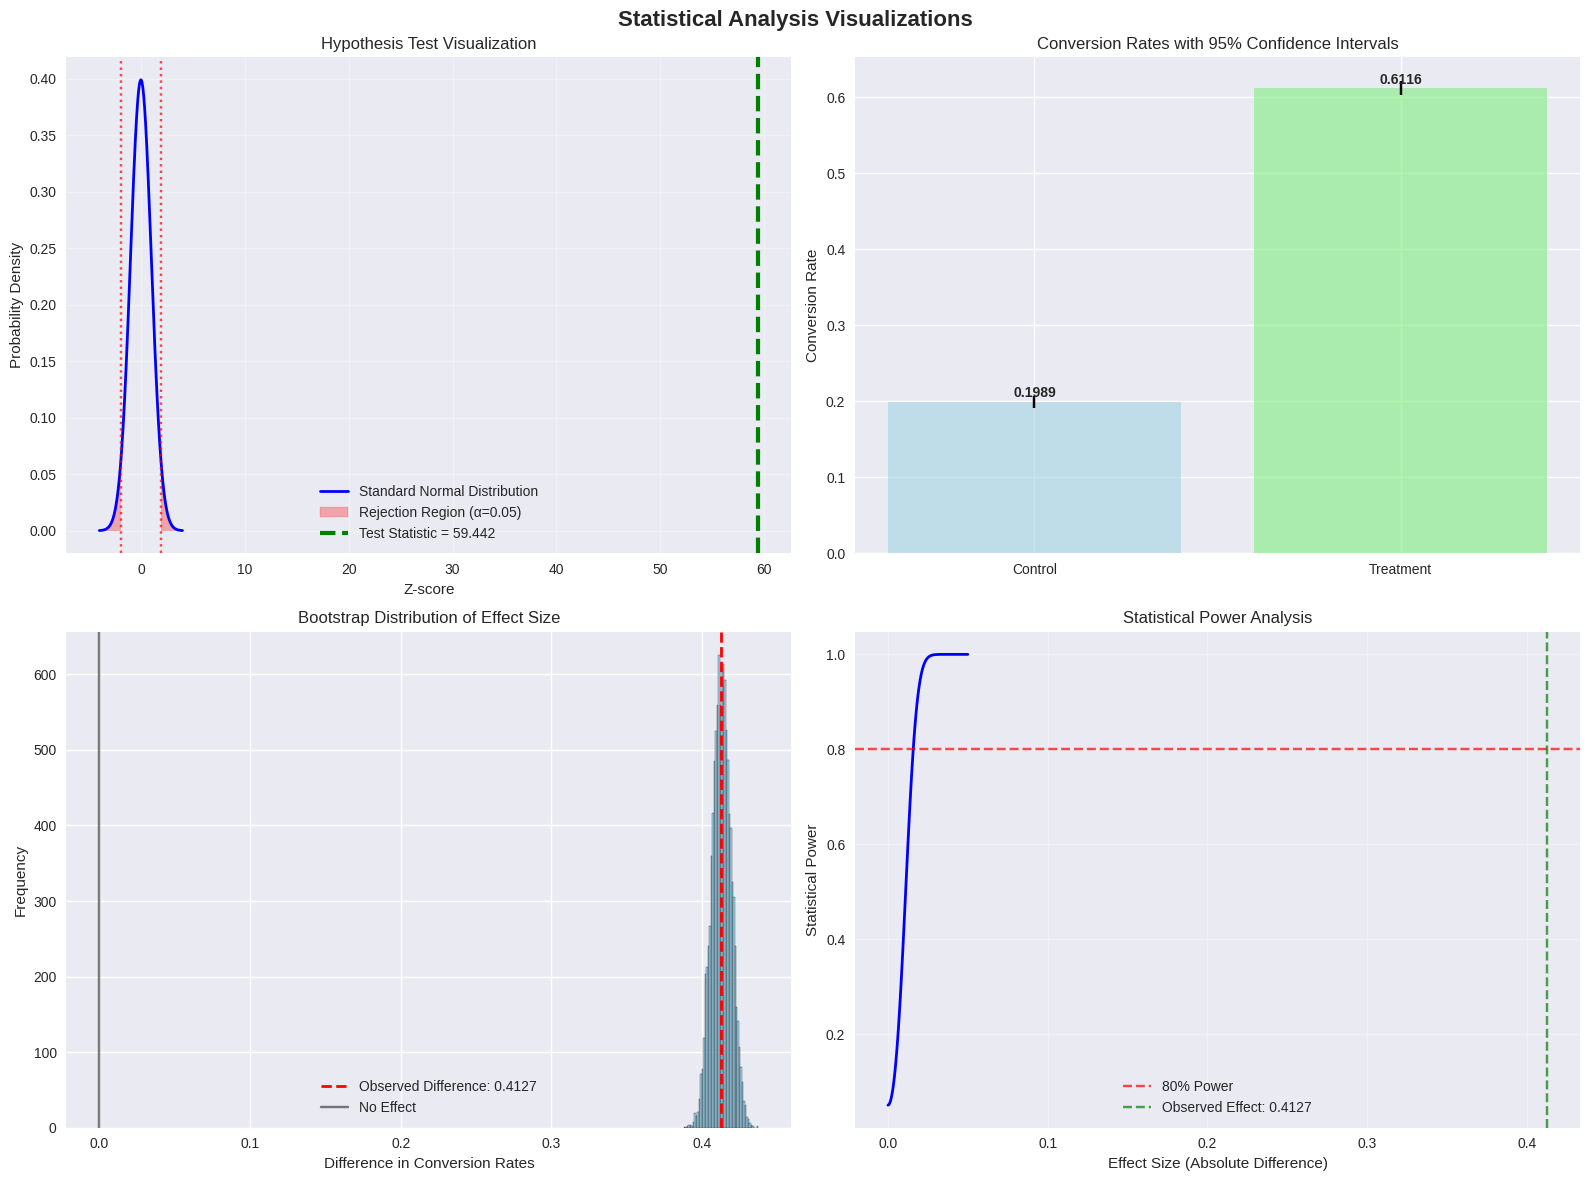

In [14]:
# Create statistical plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Statistical Analysis Visualizations', fontsize=16, fontweight='bold')

# Plot 1: Hypothesis Test Visualization
ax1 = axes[0, 0]
x = np.linspace(-4, 4, 1000)
y = norm.pdf(x, 0, 1)

ax1.plot(x, y, 'b-', linewidth=2, label='Standard Normal Distribution')
ax1.fill_between(x, y, where=(x < -z_critical) | (x > z_critical),
                color='red', alpha=0.3, label=f'Rejection Region (α={alpha})')
ax1.axvline(z_stat, color='green', linestyle='--', linewidth=3,
           label=f'Test Statistic = {z_stat:.3f}')
ax1.axvline(z_critical, color='red', linestyle=':', alpha=0.7)
ax1.axvline(-z_critical, color='red', linestyle=':', alpha=0.7)

ax1.set_title('Hypothesis Test Visualization')
ax1.set_xlabel('Z-score')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Confidence Interval Visualization
ax2 = axes[0, 1]
groups = ['Control', 'Treatment']
rates = [control_rate, exp_rate]
ci_errors = [ci_control, ci_treatment]

x_pos = np.arange(len(groups))
bars = ax2.bar(x_pos, rates, yerr=[[rates[i] - ci_errors[i][0] for i in range(2)],
                                   [ci_errors[i][1] - rates[i] for i in range(2)]],
               capsize=10, color=['lightblue', 'lightgreen'], alpha=0.7)

ax2.set_title('Conversion Rates with 95% Confidence Intervals')
ax2.set_ylabel('Conversion Rate')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(groups)

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, rates)):
    ax2.text(bar.get_x() + bar.get_width()/2, rate + 0.002,
             f'{rate:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Effect Size Distribution
ax3 = axes[1, 0]
# Simulate sampling distribution of difference
n_simulations = 10000
np.random.seed(42)

# Bootstrap sampling for effect size distribution
bootstrap_diffs = []
for _ in range(n_simulations):
    # Resample with replacement
    control_sample = np.random.binomial(1, control_rate, control_users)
    treatment_sample = np.random.binomial(1, exp_rate, exp_users)

    diff_bootstrap = np.mean(treatment_sample) - np.mean(control_sample)
    bootstrap_diffs.append(diff_bootstrap)

ax3.hist(bootstrap_diffs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax3.axvline(diff, color='red', linestyle='--', linewidth=2, label=f'Observed Difference: {diff:.4f}')
ax3.axvline(0, color='black', linestyle='-', alpha=0.5, label='No Effect')
ax3.set_title('Bootstrap Distribution of Effect Size')
ax3.set_xlabel('Difference in Conversion Rates')
ax3.set_ylabel('Frequency')
ax3.legend()

# Plot 4: Power Analysis Visualization
ax4 = axes[1, 1]
effect_sizes = np.linspace(0, 0.05, 100)
powers = []

for effect in effect_sizes:
    # Calculate power for each effect size
    delta = effect
    se_power = np.sqrt(control_rate * (1 - control_rate) * (1/control_users + 1/exp_users))
    z_power = delta / se_power
    power_calc = 1 - norm.cdf(z_critical - z_power) + norm.cdf(-z_critical - z_power)
    powers.append(power_calc)

ax4.plot(effect_sizes, powers, 'b-', linewidth=2)
ax4.axhline(0.8, color='red', linestyle='--', alpha=0.7, label='80% Power')
ax4.axvline(abs(diff), color='green', linestyle='--', alpha=0.7,
           label=f'Observed Effect: {abs(diff):.4f}')
ax4.set_title('Statistical Power Analysis')
ax4.set_xlabel('Effect Size (Absolute Difference)')
ax4.set_ylabel('Statistical Power')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 10: Business Recommendation

In [15]:
if is_significant and is_practically_significant:
    recommendation = "IMPLEMENT"
    color = "🟢"
elif is_significant and not is_practically_significant:
    recommendation = "MONITOR"
    color = "🟡"
else:
    recommendation = "DO NOT IMPLEMENT"
    color = "🔴"

print(f"{color} RECOMMENDATION: {recommendation}")

print(f"\nKEY FINDINGS:")
print(f"• Sample Size: {len(df):,} total users")
print(f"• Treatment Effect: {relative_lift:+.2f}% relative lift")
print(f"• Statistical Significance: {'Yes' if is_significant else 'No'} (p={p_value_z:.4f})")
print(f"• Practical Significance: {'Yes' if is_practically_significant else 'No'}")
print(f"• Confidence Level: 95%")

if recommendation == "IMPLEMENT":
    print(f"\nIMPLEMENTATION RATIONALE:")
    print(f"• The treatment shows both statistical and practical significance")
    print(f"• Expected conversion rate improvement: {relative_lift:.2f}%")
    print(f"• Risk of false positive: {p_value_z*100:.2f}%")

elif recommendation == "MONITOR":
    print(f"\nMONITORING RATIONALE:")
    print(f"• The treatment shows statistical significance but limited practical impact")
    print(f"• Consider longer testing period or larger sample size")
    print(f"• Monitor for sustained effects over time")

else:
    print(f"\nREJECTION RATIONALE:")
    print(f"• Insufficient evidence of treatment effect")
    print(f"• Results could be due to random variation")
    print(f"• Consider alternative treatments or longer testing period")

print(f"\nRISK ASSESSMENT:")
print(f"• Type I Error Risk (False Positive): {alpha*100:.1f}%")
print(f"• Type II Error Risk (False Negative): {beta*100:.1f}%")

print(f"\nNEXT STEPS:")
if recommendation == "IMPLEMENT":
    print(f"1. Proceed with full rollout to all users")
    print(f"2. Monitor post-implementation metrics")
    print(f"3. Document learnings for future tests")
elif recommendation == "MONITOR":
    print(f"1. Extend test duration for more data")
    print(f"2. Consider segmented analysis")
    print(f"3. Evaluate cost-benefit of small improvements")
else:
    print(f"1. Investigate alternative treatments")
    print(f"2. Conduct qualitative research")
    print(f"3. Re-evaluate success metrics")

🟢 RECOMMENDATION: IMPLEMENT

KEY FINDINGS:
• Sample Size: 20,000 total users
• Treatment Effect: +207.49% relative lift
• Statistical Significance: Yes (p=0.0000)
• Practical Significance: Yes
• Confidence Level: 95%

IMPLEMENTATION RATIONALE:
• The treatment shows both statistical and practical significance
• Expected conversion rate improvement: 207.49%
• Risk of false positive: 0.00%

RISK ASSESSMENT:
• Type I Error Risk (False Positive): 5.0%
• Type II Error Risk (False Negative): 20.0%

NEXT STEPS:
1. Proceed with full rollout to all users
2. Monitor post-implementation metrics
3. Document learnings for future tests


# Section 11: Feature Analysis

In [23]:
# Prepare features for modeling
categorical_features = ['country', 'timezone', 'device_type', 'browser', 'connection_speed']
numerical_features = ['age', 'sessions_last_30d', 'pages_per_session', 'time_on_site_min',
                     'is_returning_user', 'email_subscriber', 'cart_abandonment_rate',
                     'hour_of_day', 'day_of_week', 'is_weekend', 'treatment']

# Encode categorical variables
le_dict = {}
df_encoded = df.copy()

for feature in categorical_features:
    le = LabelEncoder()
    df_encoded[feature] = le.fit_transform(df_encoded[feature])
    le_dict[feature] = le

# Prepare feature matrix and target
X = df_encoded[numerical_features + categorical_features]
y = df_encoded['converted']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Feature matrix shape: (20000, 16)
Target distribution: {0: 11895, 1: 8105}
Training set: (16000, 16), Test set: (4000, 16)


In [20]:
numeric_columns = X_train.select_dtypes(include=[np.number]).columns

# Create polynomial features for top important features (if you have them)
# For now, we'll use all numeric features but limit degree to avoid explosion
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Apply to a subset of most important features to avoid curse of dimensionality
if len(numeric_columns) > 10:
# Use only top 10 numeric features to create interactions
  top_features = numeric_columns[:10]
  X_train_poly = poly.fit_transform(X_train[top_features])
  X_test_poly = poly.transform(X_test[top_features])

  # Create feature names
  poly_feature_names = poly.get_feature_names_out(top_features)

  # Add back to original dataframe
  X_train_enhanced = pd.concat([
    X_train.reset_index(drop=True),
    pd.DataFrame(X_train_poly, columns=poly_feature_names)
  ], axis=1)

  X_test_enhanced = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(X_test_poly, columns=poly_feature_names)
  ], axis=1)
else:
    X_train_enhanced = X_train.copy()
    X_test_enhanced = X_test.copy()

In [26]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Fit model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    model_results[name] = {
        'model': model,
        'auc_score': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"  AUC Score: {auc_score:.4f}")
    print(f"  CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Select best model
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc_score'])
best_model = model_results[best_model_name]['model']

print(f"\nBest Model: {best_model_name} (AUC: {model_results[best_model_name]['auc_score']:.4f})")


Training Logistic Regression...
  AUC Score: 0.7185
  CV AUC: 0.7171 (+/- 0.0152)

Training Random Forest...
  AUC Score: 0.7149
  CV AUC: 0.7156 (+/- 0.0141)

Training Gradient Boosting...
  AUC Score: 0.7164
  CV AUC: 0.7185 (+/- 0.0144)

Best Model: Logistic Regression (AUC: 0.7185)


Model uses coefficients instead of feature_importances_
Top 10 Most Important Features (based on coefficients):
          feature  importance
        treatment    1.851466
       is_weekend    0.049287
      device_type    0.031704
 email_subscriber    0.031445
is_returning_user    0.030622
 connection_speed    0.015395
          browser    0.009394
          country    0.009182
      hour_of_day    0.008004
      day_of_week    0.007837


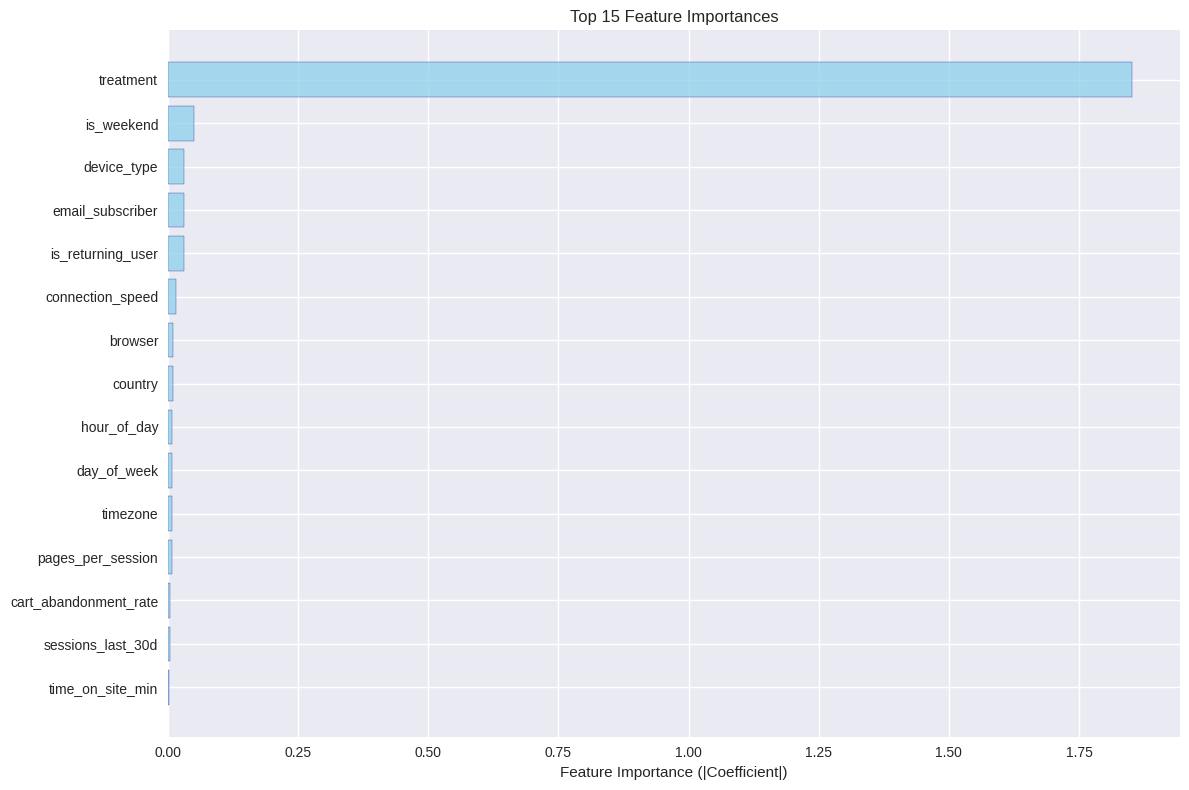

In [27]:
# Check if the model has feature importance attributes
if hasattr(best_model, 'feature_importances_'):
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

    # Create comprehensive visualization
    plt.figure(figsize=(15, 10))

    # Get top 15 features for visualization
    top_features = feature_importance.head(15)

    # Subplot 1: Horizontal bar chart of top features
    plt.subplot(2, 2, 1)
    bars = plt.barh(range(len(top_features)), top_features['importance'],
                    color='skyblue', edgecolor='navy', alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()  # Highest importance at top

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + max(top_features['importance']) * 0.01,
                bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=9)

    # Subplot 2: Vertical bar chart for comparison
    plt.subplot(2, 2, 2)
    plt.bar(range(len(top_features)), top_features['importance'],
            color='lightcoral', edgecolor='darkred', alpha=0.7)
    plt.xticks(range(len(top_features)), top_features['feature'],
               rotation=45, ha='right')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance (Vertical View)')
    plt.tight_layout()

    # Subplot 3: Cumulative importance
    plt.subplot(2, 2, 3)
    cumulative_importance = np.cumsum(feature_importance['importance'])
    plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance,
             marker='o', linestyle='-', markersize=3)
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Feature Importance')
    plt.grid(True, alpha=0.3)

    # Add line showing 80% and 95% importance thresholds
    total_importance = cumulative_importance[-1]
    plt.axhline(y=total_importance * 0.8, color='red', linestyle='--',
                alpha=0.7, label='80% threshold')
    plt.axhline(y=total_importance * 0.95, color='orange', linestyle='--',
                alpha=0.7, label='95% threshold')
    plt.legend()

    # Subplot 4: Distribution of feature importances
    plt.subplot(2, 2, 4)
    plt.hist(feature_importance['importance'], bins=20,
             color='lightgreen', edgecolor='darkgreen', alpha=0.7)
    plt.xlabel('Feature Importance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Feature Importances')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print additional statistics
    print(f"\nFeature Importance Statistics:")
    print(f"Total number of features: {len(feature_importance)}")
    print(f"Mean importance: {feature_importance['importance'].mean():.4f}")
    print(f"Std deviation: {feature_importance['importance'].std():.4f}")
    print(f"Max importance: {feature_importance['importance'].max():.4f}")
    print(f"Min importance: {feature_importance['importance'].min():.4f}")

    # Find how many features account for 80% of importance
    cumsum_norm = cumulative_importance / total_importance
    features_80_percent = np.where(cumsum_norm >= 0.8)[0][0] + 1
    features_95_percent = np.where(cumsum_norm >= 0.95)[0][0] + 1

    print(f"\nFeatures accounting for 80% of importance: {features_80_percent}")
    print(f"Features accounting for 95% of importance: {features_95_percent}")

    # Return the feature importance DataFrame for further analysis
    feature_importance_df = feature_importance

elif hasattr(best_model, 'coef_'):
    # For linear models, use coefficients as feature importance
    print("Model uses coefficients instead of feature_importances_")

    # Handle both single and multi-class scenarios
    if len(best_model.coef_.shape) == 1:
        # Binary classification or regression
        coefficients = np.abs(best_model.coef_)
    else:
        # Multi-class classification - take mean of absolute coefficients
        coefficients = np.mean(np.abs(best_model.coef_), axis=0)

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': coefficients
    }).sort_values('importance', ascending=False)

    print("Top 10 Most Important Features (based on coefficients):")
    print(feature_importance.head(10).to_string(index=False))

    # Similar visualization code as above...
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)

    plt.barh(range(len(top_features)), top_features['importance'],
             color='skyblue', edgecolor='navy', alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance (|Coefficient|)')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print("This model doesn't support feature importance extraction.")
    print("Consider using models like RandomForest, GradientBoosting, or XGBoost for feature importance.")